# White Blood Cell Segmentation: K-Means vs Fuzzy C-Means

This notebook implements and compares two clustering algorithms for segmenting white blood cells in microscopy images. We will:
- Load blood cell images and annotations
- Preprocess images (color space conversion, filtering)
- Apply K-Means clustering (hard assignment)
- Apply Fuzzy C-Means clustering (soft assignment with membership functions)
- Visualize and compare results
- Calculate performance metrics

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
import seaborn as sns
import os
from pathlib import Path
import xml.etree.ElementTree as ET
import time
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Load and Explore Dataset

Load blood cell images from the JPEGImages folder and parse annotation XML files

In [13]:
# Define dataset paths
DATASET_PATH = Path("./archive (2)/dataset-master/dataset-master")
IMAGES_DIR = DATASET_PATH / "JPEGImages"
ANNOTATIONS_DIR = DATASET_PATH / "Annotations"
LABELS_FILE = DATASET_PATH / "labels.csv"

# Check if paths exist
print(f"Dataset path exists: {DATASET_PATH.exists()}")
print(f"Images directory exists: {IMAGES_DIR.exists()}")
print(f"Annotations directory exists: {ANNOTATIONS_DIR.exists()}")
print(f"Labels file exists: {LABELS_FILE.exists()}")

# Load labels
if LABELS_FILE.exists():
    labels_df = pd.read_csv(LABELS_FILE)
    print(f"\nLabels dataframe shape: {labels_df.shape}")
    print(labels_df.head())
else:
    print("Labels file not found")

# Get list of available images
if IMAGES_DIR.exists():
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"\nTotal images available: {len(image_files)}")
    print(f"Sample images: {image_files[:5]}")
else:
    print("Images directory not found")

Dataset path exists: True
Images directory exists: True
Annotations directory exists: True
Labels file exists: True

Labels dataframe shape: (411, 3)
   Unnamed: 0  Image    Category
0         NaN      0  NEUTROPHIL
1         NaN      1  NEUTROPHIL
2         NaN      2  NEUTROPHIL
3         NaN      3  NEUTROPHIL
4         NaN      4  NEUTROPHIL

Total images available: 366
Sample images: ['BloodImage_00000.jpg', 'BloodImage_00001.jpg', 'BloodImage_00002.jpg', 'BloodImage_00003.jpg', 'BloodImage_00004.jpg']


Loaded image: BloodImage_00000.jpg
Image shape: (480, 640, 3)
Image dtype: uint8
Found 11 annotated cells
Cell types: ['RBC', 'RBC', 'RBC']


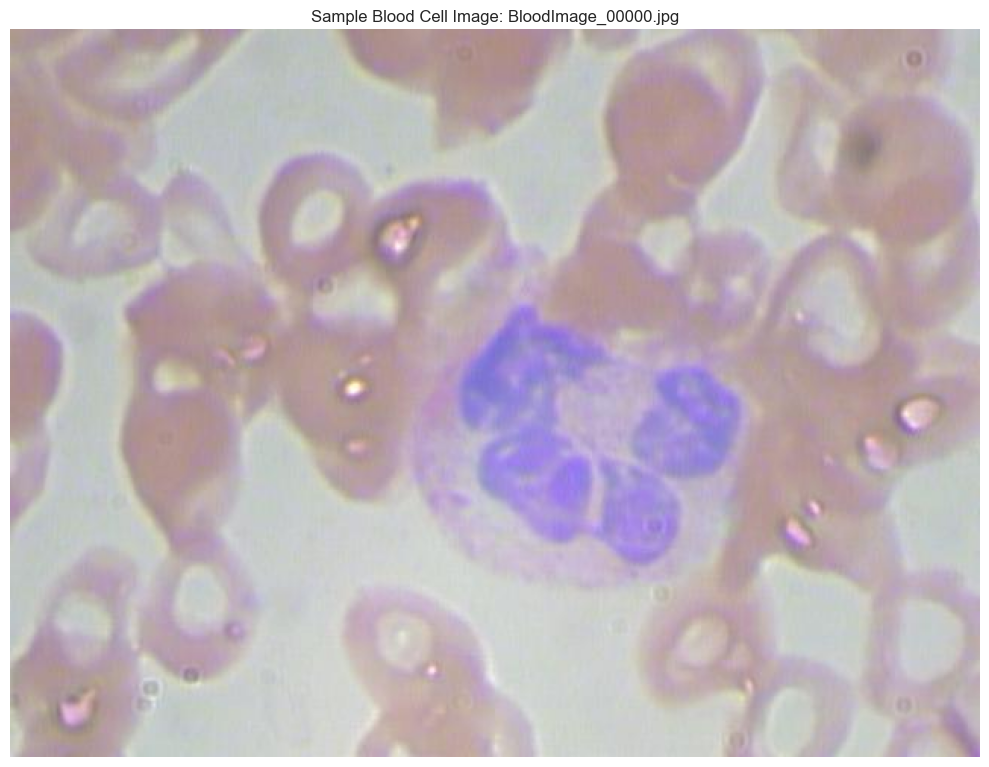

In [14]:
def load_blood_cell_image(image_path):
    """
    Load a blood cell image from file.
    
    Args:
        image_path: Path to the image file
    
    Returns:
        image: Image in BGR format (as read by OpenCV)
        image_rgb: Image converted to RGB for display
    """
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Convert BGR to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, image_rgb


def parse_annotation_xml(xml_path):
    """
    Parse XML annotation file to extract cell information.
    
    Args:
        xml_path: Path to the XML annotation file
    
    Returns:
        cells: List of dictionaries containing cell information
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        cells = []
        for obj in root.findall('object'):
            cell_name = obj.find('name')
            if cell_name is not None:
                cell_type = cell_name.text
                
                # Extract bounding box
                bndbox = obj.find('bndbox')
                if bndbox is not None:
                    bbox = {
                        'type': cell_type,
                        'xmin': int(bndbox.find('xmin').text),
                        'ymin': int(bndbox.find('ymin').text),
                        'xmax': int(bndbox.find('xmax').text),
                        'ymax': int(bndbox.find('ymax').text)
                    }
                    cells.append(bbox)
        
        return cells
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return []


# Load a sample image
if IMAGES_DIR.exists() and len(image_files) > 0:
    sample_image_name = image_files[0]
    sample_image_path = IMAGES_DIR / sample_image_name
    
    # Load image
    image, image_rgb = load_blood_cell_image(sample_image_path)
    print(f"Loaded image: {sample_image_name}")
    print(f"Image shape: {image.shape}")
    print(f"Image dtype: {image.dtype}")
    
    # Try to load corresponding annotations
    xml_name = sample_image_name.replace('.jpg', '.xml').replace('.jpeg', '.xml').replace('.png', '.xml')
    xml_path = ANNOTATIONS_DIR / xml_name
    
    if xml_path.exists():
        cells = parse_annotation_xml(xml_path)
        print(f"Found {len(cells)} annotated cells")
        if cells:
            print(f"Cell types: {[c['type'] for c in cells[:3]]}")
    
    # Display sample image
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title(f"Sample Blood Cell Image: {sample_image_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 2. Image Preprocessing

Convert to LAB color space, apply Gaussian blur for noise reduction, and normalize

[Performance] Image downsampled to (512, 384) for faster processing
Original image shape: (384, 512, 3)
Feature matrix shape: (196608, 3)
Feature matrix value range: [0.275, 0.969]
Number of pixels: 196608


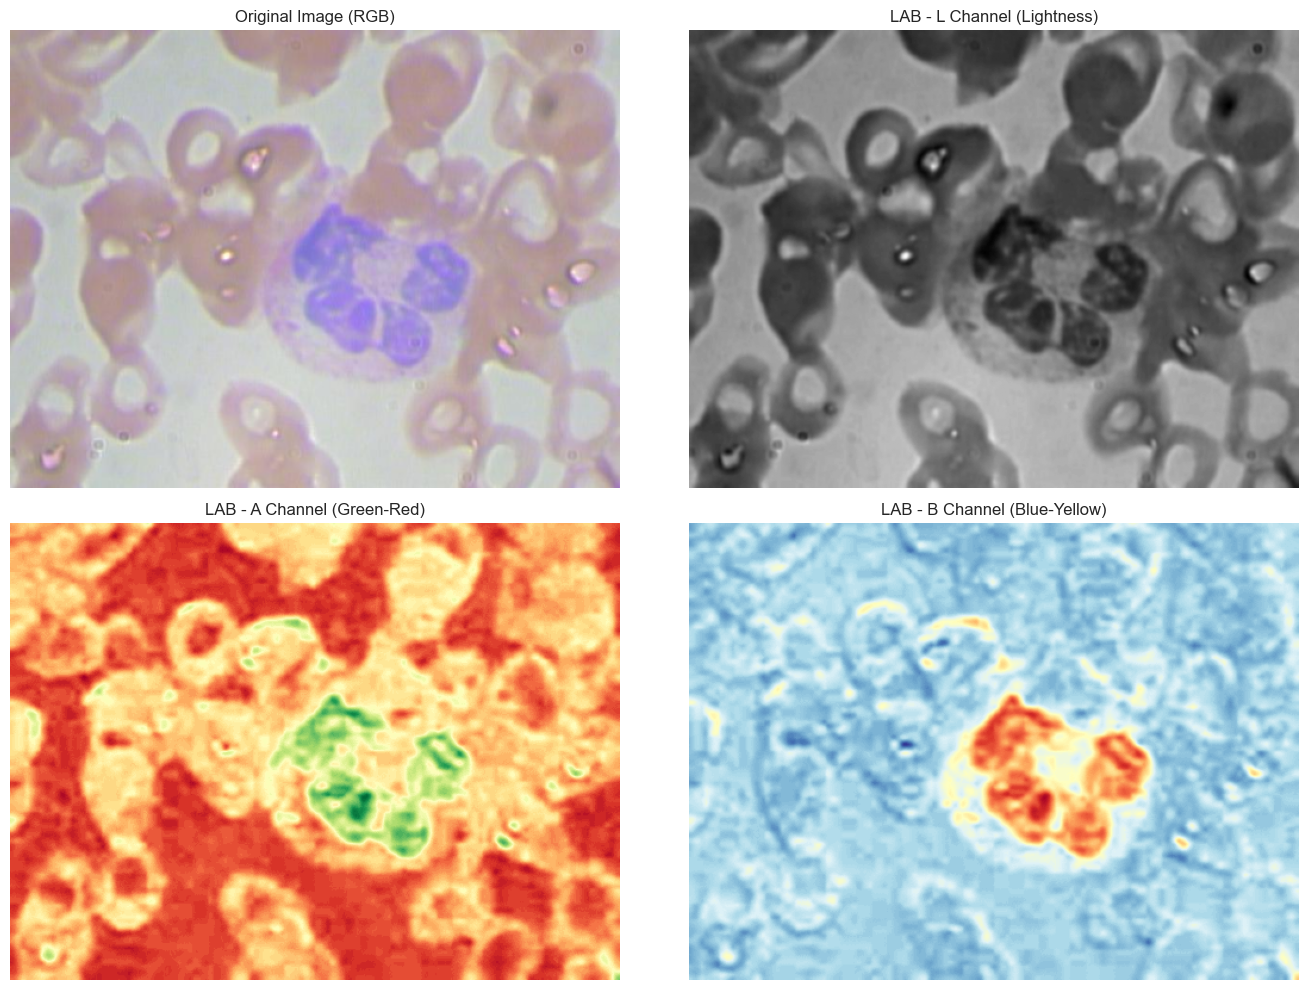

In [15]:
def preprocess_image(image_bgr):
    """
    Preprocess blood cell image: noise reduction, color space conversion, normalization.
    
    Args:
        image_bgr: Input image in BGR format (OpenCV format)
    
    Returns:
        image_lab: Image in LAB color space
        image_normalized: Normalized LAB image (0-1 range)
        image_bgr_downsampled: Downsampled BGR image (for consistency)
    """
    # Downsample image for faster processing (performance optimization)
    # Reduces pixel count from ~1M to ~260K, significantly speeds up clustering and metrics
    max_dimension = max(image_bgr.shape[:2])
    if max_dimension > 512:
        scale = 512.0 / max_dimension
        new_size = (int(image_bgr.shape[1] * scale), int(image_bgr.shape[0] * scale))
        image_bgr = cv2.resize(image_bgr, new_size, interpolation=cv2.INTER_AREA)
        print(f"[Performance] Image downsampled to {new_size} for faster processing")
    
    # Apply Gaussian blur to reduce noise
    # Kernel size (5, 5) helps smooth the image while preserving edges
    blurred = cv2.GaussianBlur(image_bgr, (5, 5), 0)
    
    # Convert BGR to LAB color space
    # LAB is better for clustering as it separates color from brightness
    image_lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
    
    # Normalize LAB image to 0-1 range for clustering
    image_normalized = image_lab.astype(np.float32) / 255.0
    
    return image_lab, image_normalized, image_bgr


def reshape_pixels_to_features(image_normalized):
    """
    Reshape pixel matrix to feature matrix for clustering.
    
    Each pixel becomes a sample with LAB values as features.
    
    Args:
        image_normalized: Normalized LAB image
    
    Returns:
        feature_matrix: Reshaped pixels (N_pixels, 3) where 3 = L, A, B channels
        original_shape: Original image shape for reconstruction
    """
    # Get image dimensions
    original_shape = image_normalized.shape
    height, width, channels = original_shape
    
    # Reshape to 2D: each row is one pixel's LAB values
    feature_matrix = image_normalized.reshape(-1, channels)
    
    return feature_matrix, original_shape


# Preprocess sample image
if IMAGES_DIR.exists() and len(image_files) > 0:
    sample_image_path = IMAGES_DIR / image_files[0]
    image_bgr_orig, image_rgb_orig = load_blood_cell_image(sample_image_path)
    
    # Preprocess (this will downsample the image)
    image_lab, image_normalized, image_bgr_downsampled = preprocess_image(image_bgr_orig)
    
    # Convert downsampled BGR to RGB for display
    image_rgb = cv2.cvtColor(image_bgr_downsampled, cv2.COLOR_BGR2RGB)
    
    feature_matrix, original_shape = reshape_pixels_to_features(image_normalized)
    
    print(f"Original image shape: {original_shape}")
    print(f"Feature matrix shape: {feature_matrix.shape}")
    print(f"Feature matrix value range: [{feature_matrix.min():.3f}, {feature_matrix.max():.3f}]")
    print(f"Number of pixels: {feature_matrix.shape[0]}")
    
    # Visualize preprocessing steps
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Original image
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title("Original Image (RGB)")
    axes[0, 0].axis('off')
    
    # LAB image visualization (L channel)
    axes[0, 1].imshow(image_lab[:, :, 0], cmap='gray')
    axes[0, 1].set_title("LAB - L Channel (Lightness)")
    axes[0, 1].axis('off')
    
    # LAB A channel
    axes[1, 0].imshow(image_lab[:, :, 1], cmap='RdYlGn')
    axes[1, 0].set_title("LAB - A Channel (Green-Red)")
    axes[1, 0].axis('off')
    
    # LAB B channel
    axes[1, 1].imshow(image_lab[:, :, 2], cmap='RdYlBu')
    axes[1, 1].set_title("LAB - B Channel (Blue-Yellow)")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

## 3. K-Means Clustering Implementation

Apply K-Means algorithm to segment white blood cells (k=3: nucleus, cytoplasm, background)

In [16]:
def apply_kmeans_clustering(feature_matrix, k=3, random_state=42):
    """
    Apply K-Means clustering algorithm to segment image pixels.
    
    K-Means performs hard assignment - each pixel belongs to exactly one cluster.
    This is suitable for crisp segmentation of cell components.
    
    Args:
        feature_matrix: Pixel feature matrix (N_pixels, 3) with LAB values
        k: Number of clusters (default 3: nucleus, cytoplasm, background)
        random_state: Random seed for reproducibility
    
    Returns:
        kmeans_model: Fitted KMeans model
        labels: Cluster assignment for each pixel
        centroids: Cluster centers in LAB space
        execution_time: Time taken for clustering
    """
    # Initialize and fit K-Means
    start_time = time.time()
    
    kmeans_model = KMeans(
        n_clusters=k,
        init='k-means++',  # Smart initialization for better convergence
        n_init=10,  # Multiple runs to ensure global optimum
        max_iter=300,
        random_state=random_state
    )
    
    labels = kmeans_model.fit_predict(feature_matrix)
    centroids = kmeans_model.cluster_centers_
    
    execution_time = time.time() - start_time
    
    return kmeans_model, labels, centroids, execution_time


def reconstruct_segmented_image(labels, original_shape, centroids, color_space='LAB'):
    """
    Reconstruct segmented image from cluster labels and centroids.
    
    Args:
        labels: Cluster assignments for each pixel
        original_shape: Original image shape (height, width, 3)
        centroids: Cluster center values in feature space
        color_space: 'LAB' or 'RGB' for reconstruction
    
    Returns:
        segmented_image: Reconstructed image with centroid colors
        label_map: Reshaped label map for visualization
    """
    # Reshape labels to image dimensions
    label_map = labels.reshape(original_shape[:2])
    
    # Create segmented image using centroid colors
    segmented_image = np.zeros(original_shape, dtype=np.uint8)
    
    for cluster_id in range(len(centroids)):
        # Get mask of pixels belonging to this cluster
        mask = label_map == cluster_id
        
        # Assign centroid values (scaled to 0-255)
        segmented_image[mask] = (centroids[cluster_id] * 255).astype(np.uint8)
    
    return segmented_image, label_map


# Apply K-Means clustering to sample image
if IMAGES_DIR.exists() and len(image_files) > 0:
    print("Applying K-Means Clustering...")
    print("="*50)
    
    kmeans_model, kmeans_labels, kmeans_centroids, kmeans_time = apply_kmeans_clustering(
        feature_matrix, k=3
    )
    
    print(f"K-Means Execution time: {kmeans_time:.4f} seconds")
    print(f"K-Means Cluster centroids shape: {kmeans_centroids.shape}")
    print(f"Cluster sizes:")
    unique, counts = np.unique(kmeans_labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(kmeans_labels)) * 100
        print(f"  Cluster {cluster_id}: {count} pixels ({percentage:.1f}%)")
    
    # Reconstruct segmented image
    kmeans_segmented, kmeans_label_map = reconstruct_segmented_image(
        kmeans_labels, original_shape, kmeans_centroids
    )
    
    # Convert LAB back to RGB for display
    kmeans_segmented_rgb = cv2.cvtColor(kmeans_segmented, cv2.COLOR_LAB2RGB)
    
    # Create color map for labels
    color_map_kmeans = np.zeros((kmeans_label_map.shape[0], kmeans_label_map.shape[1], 3), dtype=np.uint8)
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue
    for i in range(3):
        color_map_kmeans[kmeans_label_map == i] = colors[i]
    
    print(f"\nK-Means segmentation completed!")
    print(f"Segmented image shape: {kmeans_segmented_rgb.shape}")

Applying K-Means Clustering...
K-Means Execution time: 1.2947 seconds
K-Means Cluster centroids shape: (3, 3)
Cluster sizes:
  Cluster 0: 11766 pixels (6.0%)
  Cluster 1: 89670 pixels (45.6%)
  Cluster 2: 95172 pixels (48.4%)

K-Means segmentation completed!
Segmented image shape: (384, 512, 3)


## 4. Fuzzy C-Means Clustering Implementation

Apply Fuzzy C-Means algorithm for soft clustering (membership functions)

In [17]:
def apply_fuzzy_cmeans_clustering(feature_matrix, c=3, m=2, max_iter=100, error=1e-3):
    """
    Apply Fuzzy C-Means (FCM) clustering algorithm.
    
    FCM performs soft assignment - each pixel has a membership degree (0-1) for each cluster.
    This handles uncertain boundaries better than hard clustering.
    
    Parameters:
        feature_matrix: Pixel feature matrix (N_pixels, 3) with LAB values
        c: Number of clusters (default 3)
        m: Fuzziness parameter (default 2): higher = fuzzier memberships
        max_iter: Maximum number of iterations
        error: Convergence threshold
    
    Returns:
        cntr: Cluster centers
        u: Membership matrix (c, N_pixels) - degree of belonging to each cluster
        u0: Initial membership matrix
        d: FCM objective function values
        jm: Jacobian matrix
        p: Partition coefficient
        fpc: Fuzzy partition coefficient
        execution_time: Time taken for clustering
    """
    start_time = time.time()
    
    # Transpose feature matrix for skfuzzy (features x samples)
    data = feature_matrix.T  # Shape: (3, N_pixels)
    
    # Apply Fuzzy C-Means
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data,
        c=c,
        m=m,
        maxiter=max_iter,
        error=error,
        init=None,
        seed=42
    )
    
    execution_time = time.time() - start_time
    
    return cntr, u, u0, d, jm, p, fpc, execution_time


def get_fuzzy_labels(u):
    """
    Convert fuzzy membership matrix to hard labels.
    
    Args:
        u: Membership matrix (C, N_pixels)
    
    Returns:
        labels: Hard cluster assignment based on maximum membership
    """
    # Get label for each pixel: cluster with highest membership
    labels = np.argmax(u, axis=0)
    return labels


def reconstruct_fuzzy_segmented_image(u, original_shape, cntr):
    """
    Reconstruct segmented image from fuzzy membership matrix.
    
    Uses weighted reconstruction with membership degrees.
    
    Args:
        u: Membership matrix (C, N_pixels)
        original_shape: Original image shape (height, width, 3)
        cntr: Cluster centers
    
    Returns:
        segmented_image: Reconstructed image
        fuzzy_image: Soft segmentation visualization
        label_map: Hard label map
    """
    # Get hard labels
    labels = get_fuzzy_labels(u)
    label_map = labels.reshape(original_shape[:2])
    
    # Create hard segmentation using centroids
    segmented_image = np.zeros(original_shape, dtype=np.uint8)
    for cluster_id in range(len(cntr)):
        mask = label_map == cluster_id
        segmented_image[mask] = (cntr[cluster_id] * 255).astype(np.uint8)
    
    # Create soft segmentation visualization (confidence map)
    # Use maximum membership as confidence
    max_membership = np.max(u, axis=0)
    fuzzy_image = (max_membership * 255).astype(np.uint8).reshape(original_shape[:2])
    
    return segmented_image, fuzzy_image, label_map


# Apply Fuzzy C-Means clustering
if IMAGES_DIR.exists() and len(image_files) > 0:
    print("\nApplying Fuzzy C-Means Clustering...")
    print("="*50)
    
    fcm_cntr, fcm_u, fcm_u0, fcm_d, fcm_jm, fcm_p, fcm_fpc, fcm_time = apply_fuzzy_cmeans_clustering(
        feature_matrix, c=3, m=2, max_iter=30
    )
    
    print(f"Fuzzy C-Means Execution time: {fcm_time:.4f} seconds")
    print(f"FCM Cluster centers shape: {fcm_cntr.shape}")
    print(f"FCM Membership matrix shape: {fcm_u.shape}")
    print(f"Partition Coefficient: {fcm_p:.4f}")
    print(f"Fuzzy Partition Coefficient: {fcm_fpc:.4f}")
    
    # Get hard labels from fuzzy membership
    fcm_labels = get_fuzzy_labels(fcm_u)
    
    print(f"Cluster sizes:")
    unique, counts = np.unique(fcm_labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(fcm_labels)) * 100
        print(f"  Cluster {cluster_id}: {count} pixels ({percentage:.1f}%)")
    
    # Reconstruct segmented images
    fcm_segmented, fcm_fuzzy_image, fcm_label_map = reconstruct_fuzzy_segmented_image(
        fcm_u, original_shape, fcm_cntr
    )
    
    # Convert LAB to RGB
    fcm_segmented_rgb = cv2.cvtColor(fcm_segmented, cv2.COLOR_LAB2RGB)
    
    # Create color map
    color_map_fcm = np.zeros((fcm_label_map.shape[0], fcm_label_map.shape[1], 3), dtype=np.uint8)
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue
    for i in range(3):
        color_map_fcm[fcm_label_map == i] = colors[i]
    
    print(f"\nFuzzy C-Means segmentation completed!")


Applying Fuzzy C-Means Clustering...
Fuzzy C-Means Execution time: 4.6521 seconds
FCM Cluster centers shape: (3, 3)
FCM Membership matrix shape: (3, 196608)
Partition Coefficient: 30.0000
Fuzzy Partition Coefficient: 0.7052
Cluster sizes:
  Cluster 0: 76943 pixels (39.1%)
  Cluster 1: 55301 pixels (28.1%)
  Cluster 2: 64364 pixels (32.7%)

Fuzzy C-Means segmentation completed!


## 5. Segmentation Results Visualization

Display original and segmented images side-by-side with color-coded clusters

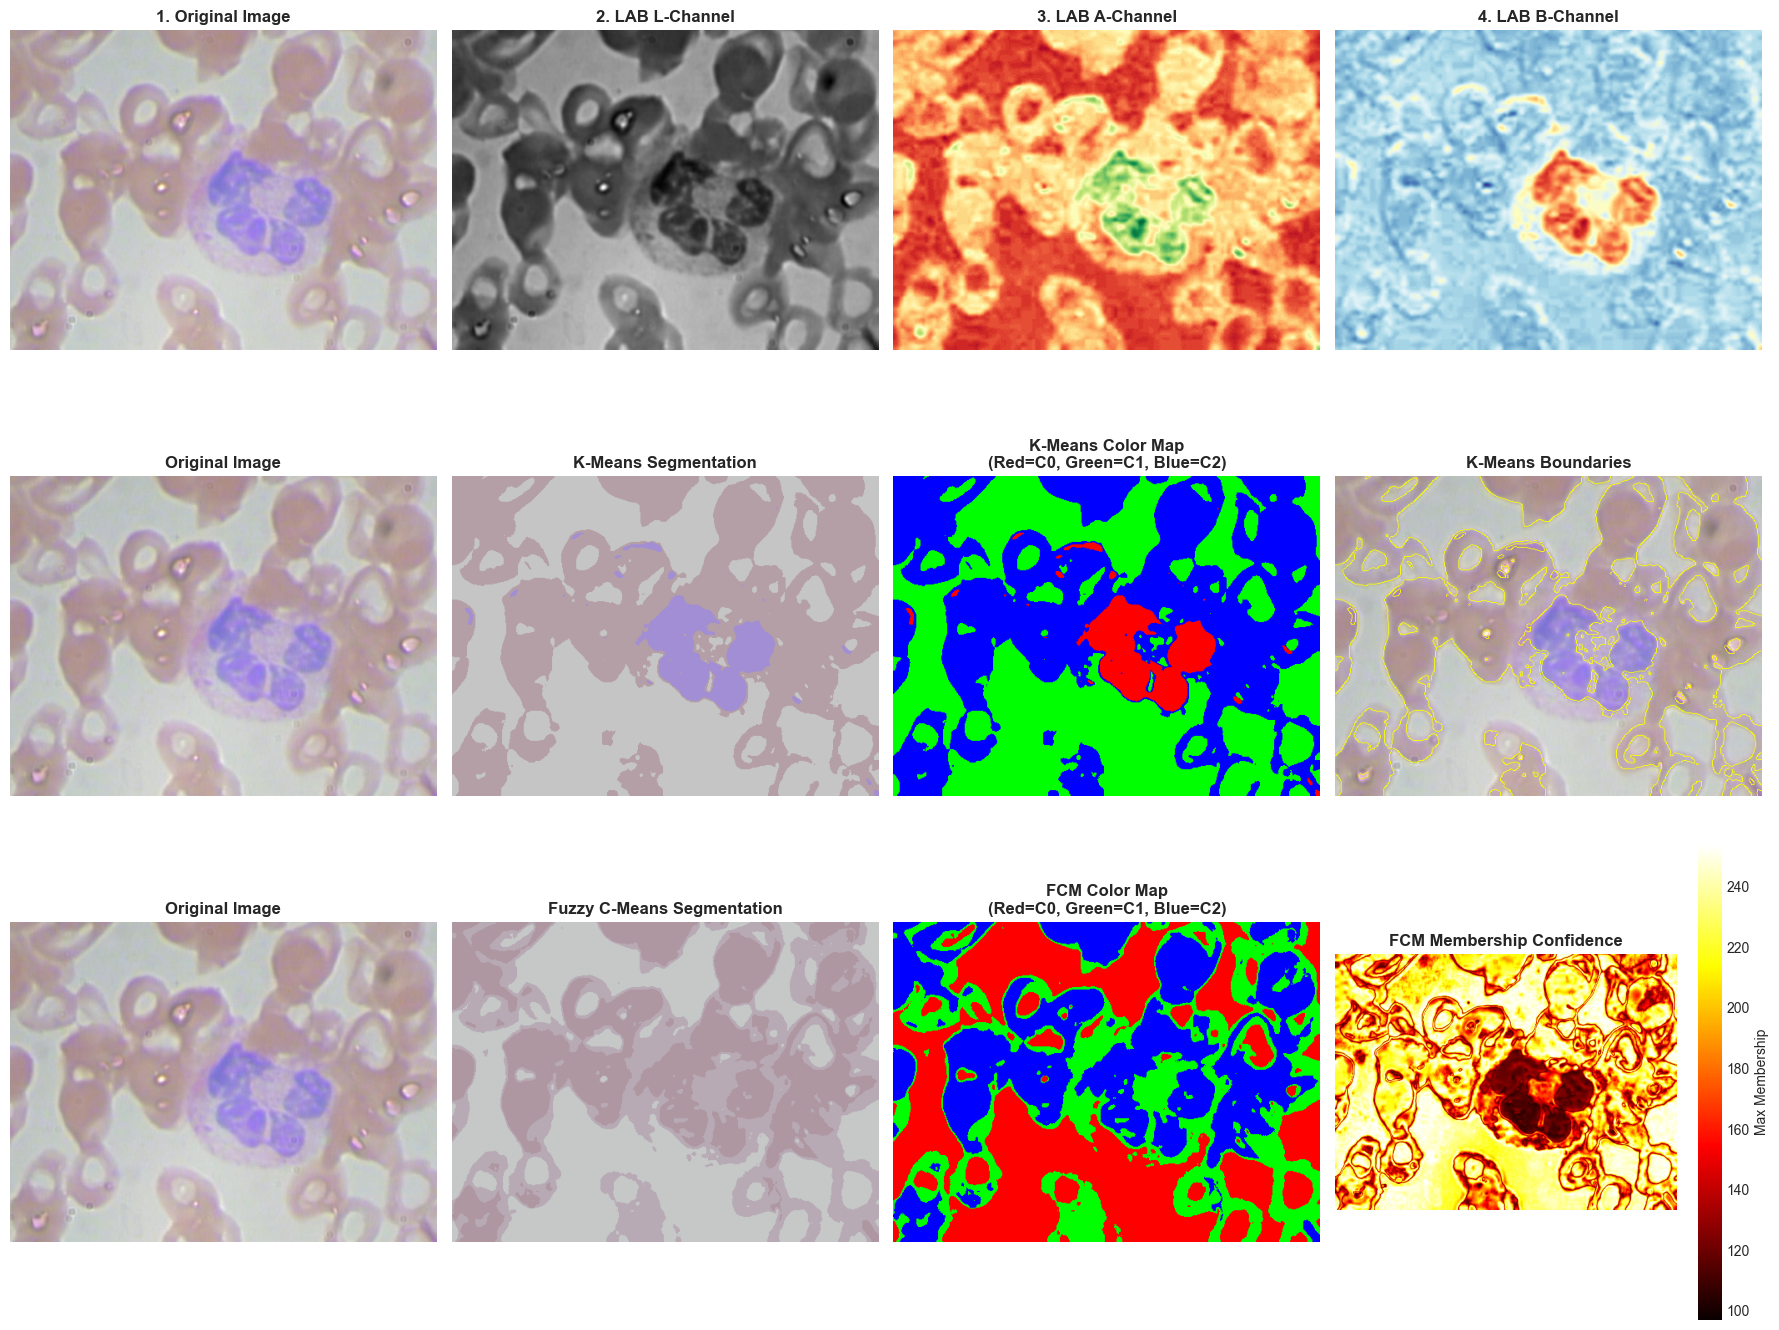


SEGMENTATION RESULTS SUMMARY
Image dimensions: 384 x 512 pixels
Total pixels: 196,608
Number of clusters: 3 (Nucleus, Cytoplasm, Background)

K-Means Execution Time: 1.2947 seconds
Fuzzy C-Means Execution Time: 4.6521 seconds
Time Ratio (FCM/KMeans): 3.59x


In [18]:
# Comprehensive visualization of all results
if IMAGES_DIR.exists() and len(image_files) > 0:
    fig, axes = plt.subplots(3, 4, figsize=(18, 14))
    
    # Row 1: Original Image and Preprocessing
    # Original
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title("1. Original Image", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # LAB L-channel
    axes[0, 1].imshow(image_lab[:, :, 0], cmap='gray')
    axes[0, 1].set_title("2. LAB L-Channel", fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # LAB A-channel
    axes[0, 2].imshow(image_lab[:, :, 1], cmap='RdYlGn')
    axes[0, 2].set_title("3. LAB A-Channel", fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # LAB B-channel
    axes[0, 3].imshow(image_lab[:, :, 2], cmap='RdYlBu')
    axes[0, 3].set_title("4. LAB B-Channel", fontsize=12, fontweight='bold')
    axes[0, 3].axis('off')
    
    # Row 2: K-Means Results
    # Original for comparison
    axes[1, 0].imshow(image_rgb)
    axes[1, 0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # K-Means segmented
    axes[1, 1].imshow(kmeans_segmented_rgb)
    axes[1, 1].set_title("K-Means Segmentation", fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    # K-Means color-coded
    axes[1, 2].imshow(color_map_kmeans)
    axes[1, 2].set_title("K-Means Color Map\n(Red=C0, Green=C1, Blue=C2)", fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    # K-Means contours
    kmeans_edges = cv2.Canny((kmeans_label_map * 85).astype(np.uint8), 50, 150)
    edge_overlay_kmeans = image_rgb.copy()
    edge_overlay_kmeans[kmeans_edges > 0] = [255, 255, 0]  # Yellow edges
    axes[1, 3].imshow(edge_overlay_kmeans)
    axes[1, 3].set_title("K-Means Boundaries", fontsize=12, fontweight='bold')
    axes[1, 3].axis('off')
    
    # Row 3: Fuzzy C-Means Results
    # Original for comparison
    axes[2, 0].imshow(image_rgb)
    axes[2, 0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[2, 0].axis('off')
    
    # FCM segmented
    axes[2, 1].imshow(fcm_segmented_rgb)
    axes[2, 1].set_title("Fuzzy C-Means Segmentation", fontsize=12, fontweight='bold')
    axes[2, 1].axis('off')
    
    # FCM color-coded
    axes[2, 2].imshow(color_map_fcm)
    axes[2, 2].set_title("FCM Color Map\n(Red=C0, Green=C1, Blue=C2)", fontsize=12, fontweight='bold')
    axes[2, 2].axis('off')
    
    # FCM membership confidence map
    im = axes[2, 3].imshow(fcm_fuzzy_image, cmap='hot')
    axes[2, 3].set_title("FCM Membership Confidence", fontsize=12, fontweight='bold')
    axes[2, 3].axis('off')
    plt.colorbar(im, ax=axes[2, 3], label='Max Membership')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison summary
    print("\n" + "="*60)
    print("SEGMENTATION RESULTS SUMMARY")
    print("="*60)
    print(f"Image dimensions: {image_rgb.shape[0]} x {image_rgb.shape[1]} pixels")
    print(f"Total pixels: {image_rgb.shape[0] * image_rgb.shape[1]:,}")
    print(f"Number of clusters: 3 (Nucleus, Cytoplasm, Background)")
    print(f"\nK-Means Execution Time: {kmeans_time:.4f} seconds")
    print(f"Fuzzy C-Means Execution Time: {fcm_time:.4f} seconds")
    print(f"Time Ratio (FCM/KMeans): {fcm_time/kmeans_time:.2f}x")

## 6. Nucleus Identification and Boundary Comparison

Identify nucleus cluster and compare cluster boundaries


NUCLEUS IDENTIFICATION
K-Means Nucleus Cluster ID: 0
K-Means Nucleus Area: 11766 pixels

Fuzzy C-Means Nucleus Cluster ID: 1
Fuzzy C-Means Nucleus Area: 55301 pixels
Area Difference: 43535 pixels

BOUNDARY COMPARISON
Boundary Jaccard Index: 0.2147
(1.0 = perfect agreement, 0.0 = no overlap)


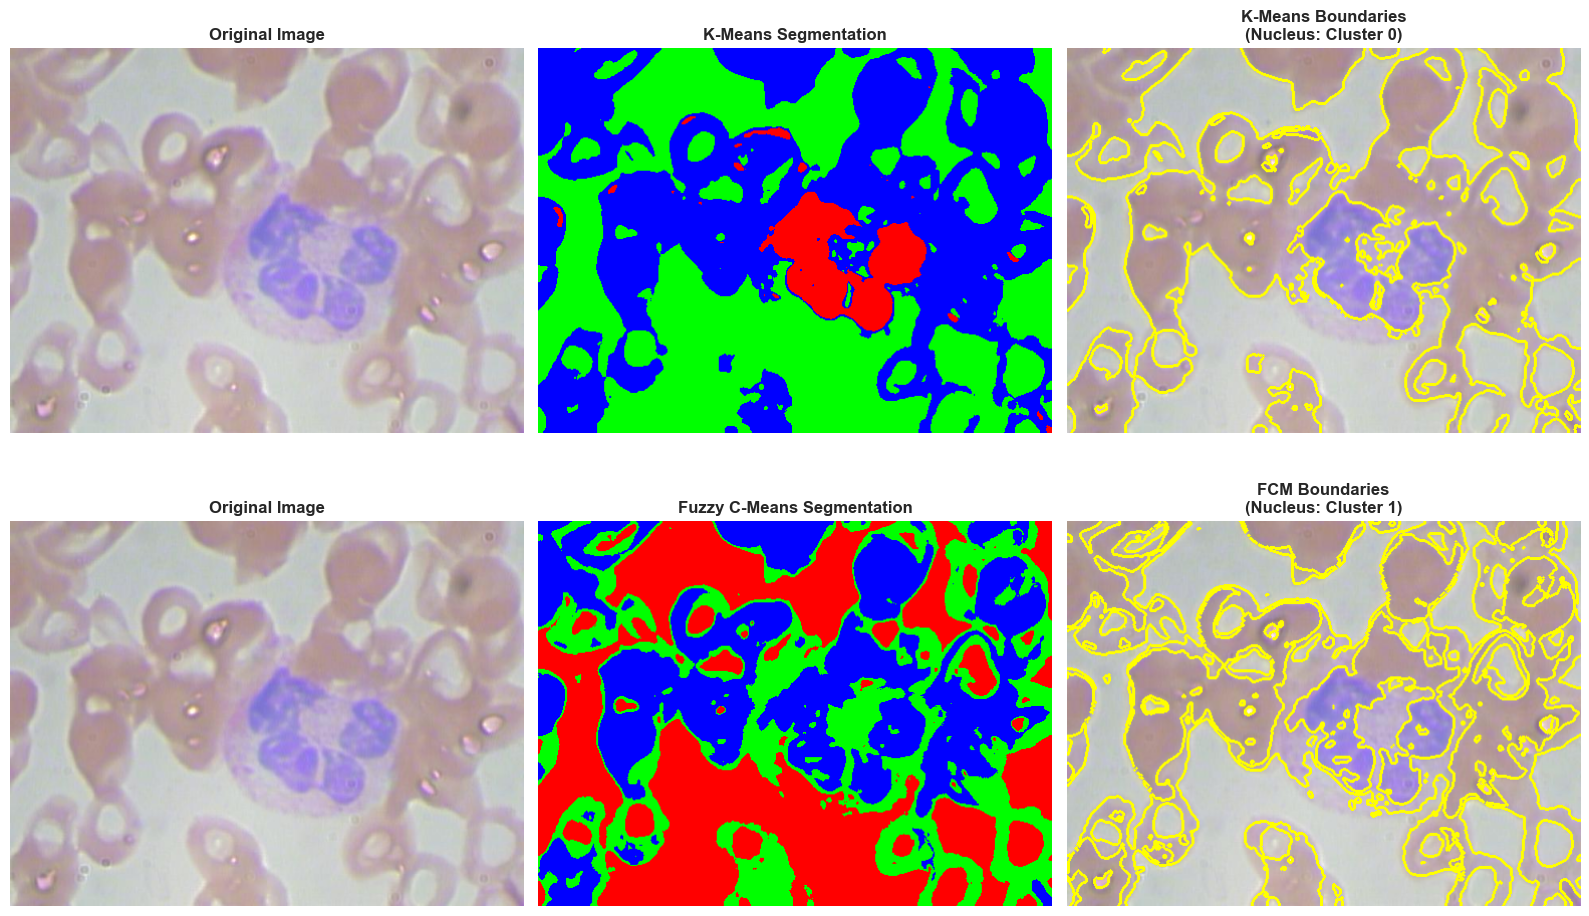

In [19]:
def identify_nucleus_cluster(label_map, image_rgb):
    """
    Identify the nucleus cluster (typically darkest region with smallest area).
    
    Args:
        label_map: Cluster assignment map
        image_rgb: Original image in RGB
    
    Returns:
        nucleus_cluster_id: Cluster ID corresponding to nucleus
        nucleus_mask: Binary mask of nucleus
        nucleus_area: Number of nucleus pixels
    """
    # Count pixels in each cluster
    unique_labels = np.unique(label_map)
    cluster_sizes = {}
    
    for label in unique_labels:
        cluster_sizes[label] = np.sum(label_map == label)
    
    # Nucleus is typically a smaller, darker region
    # Find the cluster with smallest area (usually nucleus)
    nucleus_cluster_id = min(cluster_sizes, key=cluster_sizes.get)
    nucleus_area = cluster_sizes[nucleus_cluster_id]
    nucleus_mask = (label_map == nucleus_cluster_id).astype(np.uint8)
    
    return nucleus_cluster_id, nucleus_mask, nucleus_area


def get_cluster_boundaries(label_map):
    """
    Extract and visualize cluster boundaries using edge detection.
    
    Args:
        label_map: Cluster assignment map
    
    Returns:
        boundaries: Binary map of cluster boundaries
    """
    # Scale labels for edge detection
    scaled_labels = (label_map * 85).astype(np.uint8)
    
    # Apply Canny edge detection
    edges = cv2.Canny(scaled_labels, 30, 100)
    
    # Dilate edges for better visibility
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    boundaries = cv2.dilate(edges, kernel, iterations=1)
    
    return boundaries


def compare_cluster_boundaries(kmeans_label_map, fcm_label_map, image_rgb):
    """
    Compare boundaries between K-Means and FCM segmentation.
    
    Args:
        kmeans_label_map: K-Means cluster labels
        fcm_label_map: FCM cluster labels
        image_rgb: Original image
    
    Returns:
        Analysis report and visualizations
    """
    # Get boundaries for both methods
    kmeans_boundaries = get_cluster_boundaries(kmeans_label_map)
    fcm_boundaries = get_cluster_boundaries(fcm_label_map)
    
    # Identify nucleus in both
    kmeans_nucleus_id, kmeans_nucleus_mask, kmeans_nucleus_area = identify_nucleus_cluster(kmeans_label_map, image_rgb)
    fcm_nucleus_id, fcm_nucleus_mask, fcm_nucleus_area = identify_nucleus_cluster(fcm_label_map, image_rgb)
    
    # Calculate boundary overlap
    boundary_overlap = np.sum(kmeans_boundaries & fcm_boundaries)
    boundary_union = np.sum(kmeans_boundaries | fcm_boundaries)
    boundary_jaccard = boundary_overlap / (boundary_union + 1e-6)
    
    return {
        'kmeans_boundaries': kmeans_boundaries,
        'fcm_boundaries': fcm_boundaries,
        'kmeans_nucleus_id': kmeans_nucleus_id,
        'kmeans_nucleus_mask': kmeans_nucleus_mask,
        'kmeans_nucleus_area': kmeans_nucleus_area,
        'fcm_nucleus_id': fcm_nucleus_id,
        'fcm_nucleus_mask': fcm_nucleus_mask,
        'fcm_nucleus_area': fcm_nucleus_area,
        'boundary_jaccard': boundary_jaccard
    }


# Identify nucleus and compare boundaries
if IMAGES_DIR.exists() and len(image_files) > 0:
    comparison = compare_cluster_boundaries(kmeans_label_map, fcm_label_map, image_rgb)
    
    print("\n" + "="*60)
    print("NUCLEUS IDENTIFICATION")
    print("="*60)
    print(f"K-Means Nucleus Cluster ID: {comparison['kmeans_nucleus_id']}")
    print(f"K-Means Nucleus Area: {comparison['kmeans_nucleus_area']} pixels")
    print(f"\nFuzzy C-Means Nucleus Cluster ID: {comparison['fcm_nucleus_id']}")
    print(f"Fuzzy C-Means Nucleus Area: {comparison['fcm_nucleus_area']} pixels")
    print(f"Area Difference: {abs(comparison['kmeans_nucleus_area'] - comparison['fcm_nucleus_area'])} pixels")
    
    print("\n" + "="*60)
    print("BOUNDARY COMPARISON")
    print("="*60)
    print(f"Boundary Jaccard Index: {comparison['boundary_jaccard']:.4f}")
    print("(1.0 = perfect agreement, 0.0 = no overlap)")
    
    # Visualize boundary comparison
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Row 1: K-Means
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(color_map_kmeans)
    axes[0, 1].set_title("K-Means Segmentation", fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # K-Means with boundaries
    kmeans_overlay = image_rgb.copy()
    kmeans_overlay[comparison['kmeans_boundaries'] > 0] = [255, 255, 0]  # Yellow
    axes[0, 2].imshow(kmeans_overlay)
    axes[0, 2].set_title(f"K-Means Boundaries\n(Nucleus: Cluster {comparison['kmeans_nucleus_id']})", 
                         fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: Fuzzy C-Means
    axes[1, 0].imshow(image_rgb)
    axes[1, 0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(color_map_fcm)
    axes[1, 1].set_title("Fuzzy C-Means Segmentation", fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    # FCM with boundaries
    fcm_overlay = image_rgb.copy()
    fcm_overlay[comparison['fcm_boundaries'] > 0] = [255, 255, 0]  # Yellow
    axes[1, 2].imshow(fcm_overlay)
    axes[1, 2].set_title(f"FCM Boundaries\n(Nucleus: Cluster {comparison['fcm_nucleus_id']})", 
                         fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

## 7. Performance Comparison and Metrics

Calculate segmentation metrics (Dice coefficient, Jaccard index, execution time)


PERFORMANCE METRICS CALCULATION
Image shape: (384, 512, 3)
K-Means label map shape: (384, 512)
FCM label map shape: (384, 512)
Using coarse GT mask from bounding boxes (proxy).
Boundary Jaccard Index (KM vs FCM): 0.0468


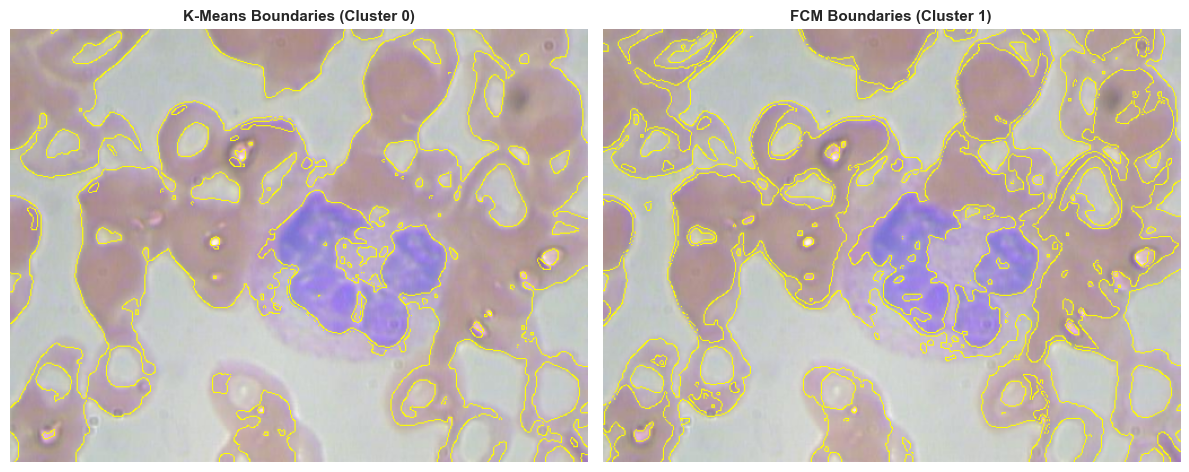

Execution Time (K-Means): 1.2947 seconds
Execution Time (FCM): 4.6521 seconds
Time Ratio (FCM/KMeans): 3.59x

       Method   Dice    IoU Execution Time (s)
      K-Means 0.0498 0.0256             1.2947
Fuzzy C-Means 0.3284 0.1965             4.6521


In [20]:
def calculate_dice_coefficient(mask1, mask2):
    """
    Calculate Dice Similarity Coefficient (DSC).
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    intersection = np.sum(mask1 & mask2)
    dice = 2 * intersection / (np.sum(mask1) + np.sum(mask2) + 1e-6)
    return dice


def calculate_iou(mask1, mask2):
    """
    Calculate Intersection over Union (IoU).
    
    IoU = |X ∩ Y| / |X ∪ Y|
    """
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    iou = intersection / (union + 1e-6)
    return iou


def ensure_label_map(labels_or_map, image_shape, name):
    """
    Ensure label map has shape (height, width).
    """
    if labels_or_map is None:
        raise ValueError(f"{name} labels are missing")
    if labels_or_map.ndim == 1:
        return labels_or_map.reshape(image_shape[:2])
    if labels_or_map.shape[:2] != image_shape[:2]:
        raise ValueError(
            f"{name} label map shape {labels_or_map.shape} does not match image {image_shape}"
        )
    return labels_or_map


def get_boundary_map(label_map):
    """
    Create a boundary map using Canny on scaled labels.
    """
    scaled_labels = (label_map * 85).astype(np.uint8)
    edges = cv2.Canny(scaled_labels, 30, 100)
    return edges


def build_gt_mask_from_annotations(image_shape, image_name, annotations_dir):
    """
    Build a coarse GT mask from bounding boxes if available.
    """
    if not annotations_dir.exists():
        return None
    xml_name = image_name.replace('.jpg', '.xml').replace('.jpeg', '.xml').replace('.png', '.xml')
    xml_path = annotations_dir / xml_name
    if not xml_path.exists():
        return None
    boxes = parse_annotation_xml(xml_path)
    if not boxes:
        return None
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    height, width = image_shape[:2]
    for box in boxes:
        xmin = max(0, min(width - 1, box['xmin']))
        xmax = max(0, min(width, box['xmax']))
        ymin = max(0, min(height - 1, box['ymin']))
        ymax = max(0, min(height, box['ymax']))
        if xmax > xmin and ymax > ymin:
            mask[ymin:ymax, xmin:xmax] = 1
    return mask


def safe_time_ratio(numerator, denominator):
    """
    Avoid division-by-zero for timing ratios.
    """
    if denominator is None or denominator <= 0:
        return float('inf')
    return numerator / denominator


if IMAGES_DIR.exists() and 'image_files' in locals() and len(image_files) > 0:
    print("\n" + "="*60)
    print("PERFORMANCE METRICS CALCULATION")
    print("="*60)

    # Ensure key arrays are aligned to image size
    image_shape = image_rgb.shape
    kmeans_label_map_local = ensure_label_map(
        kmeans_label_map if 'kmeans_label_map' in locals() else kmeans_labels,
        image_shape,
        "K-Means"
    )
    fcm_label_map_local = ensure_label_map(
        fcm_label_map if 'fcm_label_map' in locals() else fcm_labels,
        image_shape,
        "FCM"
    )

    print(f"Image shape: {image_shape}")
    print(f"K-Means label map shape: {kmeans_label_map_local.shape}")
    print(f"FCM label map shape: {fcm_label_map_local.shape}")

    # Compute nucleus masks directly in this section
    kmeans_nucleus_id, kmeans_nucleus_mask, _ = identify_nucleus_cluster(
        kmeans_label_map_local, image_rgb
    )
    fcm_nucleus_id, fcm_nucleus_mask, _ = identify_nucleus_cluster(
        fcm_label_map_local, image_rgb
    )

    # Ground truth mask if available (bbox proxy)
    gt_mask = build_gt_mask_from_annotations(image_shape, image_files[0], ANNOTATIONS_DIR)
    if gt_mask is not None:
        print("Using coarse GT mask from bounding boxes (proxy).")
        dice_kmeans = calculate_dice_coefficient(kmeans_nucleus_mask, gt_mask)
        iou_kmeans = calculate_iou(kmeans_nucleus_mask, gt_mask)
        dice_fcm = calculate_dice_coefficient(fcm_nucleus_mask, gt_mask)
        iou_fcm = calculate_iou(fcm_nucleus_mask, gt_mask)
    else:
        print("GT mask not available; reporting agreement between K-Means and FCM.")
        dice_kmeans = calculate_dice_coefficient(kmeans_nucleus_mask, fcm_nucleus_mask)
        iou_kmeans = calculate_iou(kmeans_nucleus_mask, fcm_nucleus_mask)
        dice_fcm = dice_kmeans
        iou_fcm = iou_kmeans

    # Boundary edge comparison (Canny overlay)
    kmeans_edges = get_boundary_map(kmeans_label_map_local)
    fcm_edges = get_boundary_map(fcm_label_map_local)
    boundary_overlap = np.sum((kmeans_edges > 0) & (fcm_edges > 0))
    boundary_union = np.sum((kmeans_edges > 0) | (fcm_edges > 0))
    boundary_jaccard = boundary_overlap / (boundary_union + 1e-6)

    print(f"Boundary Jaccard Index (KM vs FCM): {boundary_jaccard:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    kmeans_overlay = image_rgb.copy()
    kmeans_overlay[kmeans_edges > 0] = [255, 255, 0]
    axes[0].imshow(kmeans_overlay)
    axes[0].set_title(f"K-Means Boundaries (Cluster {kmeans_nucleus_id})", fontsize=11, fontweight='bold')
    axes[0].axis('off')

    fcm_overlay = image_rgb.copy()
    fcm_overlay[fcm_edges > 0] = [255, 255, 0]
    axes[1].imshow(fcm_overlay)
    axes[1].set_title(f"FCM Boundaries (Cluster {fcm_nucleus_id})", fontsize=11, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Execution time comparison with safe ratio
    time_ratio = safe_time_ratio(fcm_time, kmeans_time)
    print(f"Execution Time (K-Means): {kmeans_time:.4f} seconds")
    print(f"Execution Time (FCM): {fcm_time:.4f} seconds")
    print(f"Time Ratio (FCM/KMeans): {time_ratio:.2f}x")

    # Clean comparison table
    metrics_data = {
        'Method': ['K-Means', 'Fuzzy C-Means'],
        'Dice': [f"{dice_kmeans:.4f}", f"{dice_fcm:.4f}"],
        'IoU': [f"{iou_kmeans:.4f}", f"{iou_fcm:.4f}"],
        'Execution Time (s)': [f"{kmeans_time:.4f}", f"{fcm_time:.4f}"]
    }
    metrics_df = pd.DataFrame(metrics_data)
    print("\n" + metrics_df.to_string(index=False))
else:
    print("Performance metrics skipped: invalid image directory or empty image list.")

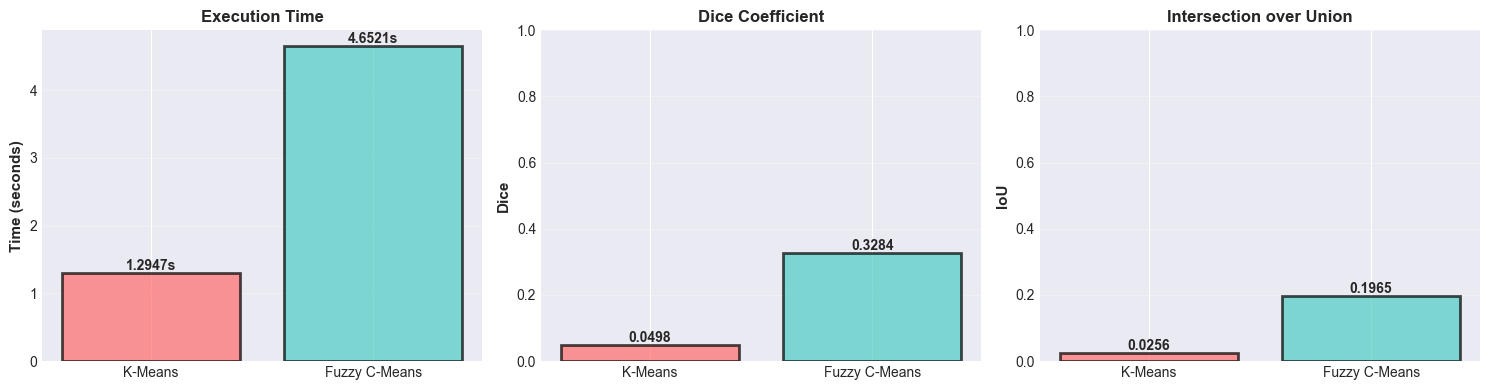

In [21]:
# Visualize simplified metrics (no silhouette/compactness)
if IMAGES_DIR.exists() and 'image_files' in locals() and len(image_files) > 0:
    if 'dice_kmeans' not in locals() or 'iou_kmeans' not in locals():
        print("Run the performance metrics cell first to compute Dice/IoU.")
    else:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # 1. Execution Time Comparison
        methods = ['K-Means', 'Fuzzy C-Means']
        times = [kmeans_time, fcm_time]
        colors = ['#FF6B6B', '#4ECDC4']

        bars1 = axes[0].bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        axes[0].set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
        axes[0].set_title('Execution Time', fontsize=12, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)
        for bar, time_val in zip(bars1, times):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                         f'{time_val:.4f}s', ha='center', va='bottom', fontweight='bold')

        # 2. Dice Comparison
        dice_scores = [dice_kmeans, dice_fcm]
        bars2 = axes[1].bar(methods, dice_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        axes[1].set_ylabel('Dice', fontsize=11, fontweight='bold')
        axes[1].set_title('Dice Coefficient', fontsize=12, fontweight='bold')
        axes[1].set_ylim([0, 1])
        axes[1].grid(axis='y', alpha=0.3)
        for bar, score in zip(bars2, dice_scores):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height,
                         f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

        # 3. IoU Comparison
        iou_scores = [iou_kmeans, iou_fcm]
        bars3 = axes[2].bar(methods, iou_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
        axes[2].set_ylabel('IoU', fontsize=11, fontweight='bold')
        axes[2].set_title('Intersection over Union', fontsize=12, fontweight='bold')
        axes[2].set_ylim([0, 1])
        axes[2].grid(axis='y', alpha=0.3)
        for bar, score in zip(bars3, iou_scores):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2., height,
                         f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()
else:
    print("Metrics visualization skipped: invalid image directory or empty image list.")

## 8. Additional Analysis: Multiple Image Processing

Process multiple images to validate algorithm performance across dataset


MULTI-IMAGE PROCESSING AND VALIDATION
Processing 5 images...

Image 1/5: BloodImage_00000.jpg
----------------------------------------------------------------------
[Performance] Image downsampled to (512, 384) for faster processing
✓ Processed successfully
  K-Means: 1.5344s, Silhouette: 0.5573
  FCM: 5.5074s, Silhouette: 0.4256
  Boundary Agreement: 0.2147

Image 2/5: BloodImage_00001.jpg
----------------------------------------------------------------------
[Performance] Image downsampled to (512, 384) for faster processing
✓ Processed successfully
  K-Means: 1.3919s, Silhouette: 0.5942
  FCM: 8.8739s, Silhouette: 0.4344
  Boundary Agreement: 0.2227

Image 3/5: BloodImage_00002.jpg
----------------------------------------------------------------------
[Performance] Image downsampled to (512, 384) for faster processing
✓ Processed successfully
  K-Means: 1.1882s, Silhouette: 0.5800
  FCM: 5.1764s, Silhouette: 0.4272
  Boundary Agreement: 0.2247

Image 4/5: BloodImage_00003.jpg
-----

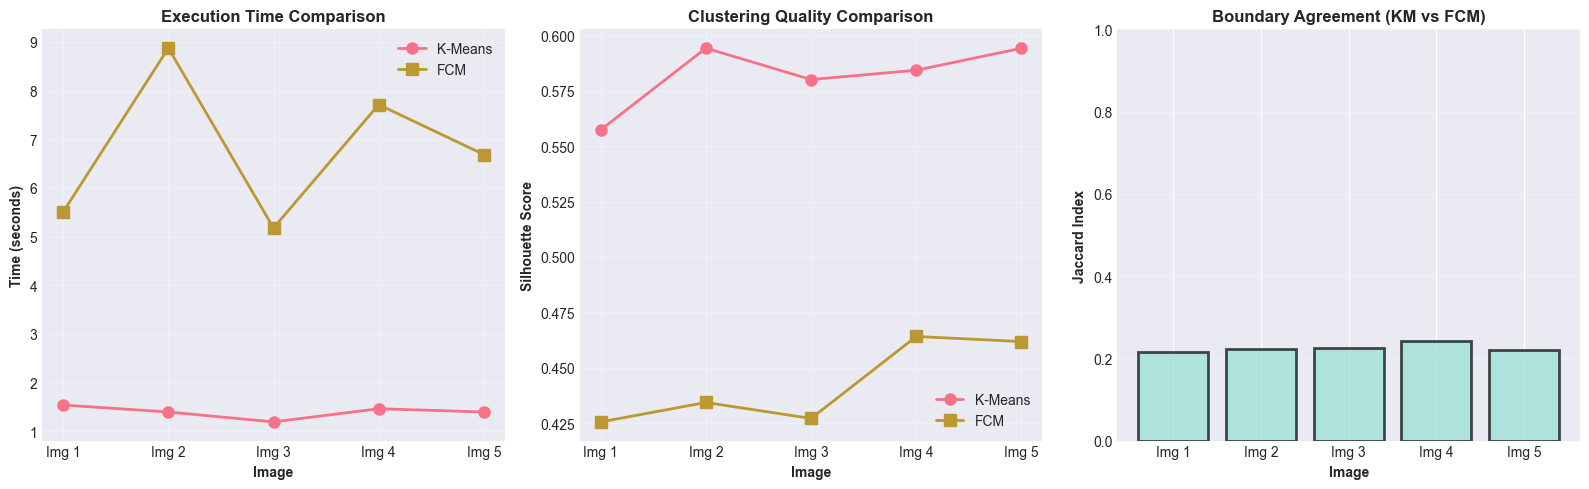

In [23]:
def calculate_silhouette_score_manual(features, labels, sample_size=5000, random_state=42):
    """
    Compute silhouette score with optional sampling to keep runtime reasonable.
    """
    try:
        unique_labels = np.unique(labels)
        if len(unique_labels) < 2 or len(unique_labels) >= len(labels):
            return 0.0
        if sample_size is not None and len(labels) > sample_size:
            rng = np.random.default_rng(random_state)
            idx = rng.choice(len(labels), size=sample_size, replace=False)
            return silhouette_score(features[idx], labels[idx])
        return silhouette_score(features, labels)
    except Exception:
        return 0.0


def process_multiple_images(image_dir, num_images=5):
    """
    Process multiple images to evaluate algorithm performance across dataset.
    
    Args:
        image_dir: Directory containing images
        num_images: Number of images to process
    
    Returns:
        results: Dictionary with metrics for all processed images
    """
    if not image_dir.exists():
        print(f"Image directory not found: {image_dir}")
        return None
    
    image_files_list = sorted([f for f in os.listdir(image_dir) 
                              if f.endswith(('.jpg', '.jpeg', '.png'))])
    
    # Limit to specified number
    image_files_list = image_files_list[:min(num_images, len(image_files_list))]
    
    results = {
        'image_name': [],
        'image_shape': [],
        'kmeans_time': [],
        'fcm_time': [],
        'kmeans_silhouette': [],
        'fcm_silhouette': [],
        'boundary_jaccard': []
    }
    
    print(f"Processing {len(image_files_list)} images...")
    print("="*70)
    
    for idx, img_file in enumerate(image_files_list, 1):
        print(f"\nImage {idx}/{len(image_files_list)}: {img_file}")
        print("-"*70)
        
        try:
            # Load and preprocess
            img_path = image_dir / img_file
            img_bgr, img_rgb = load_blood_cell_image(img_path)
            img_lab, img_normalized, _ = preprocess_image(img_bgr)
            feat_matrix, orig_shape = reshape_pixels_to_features(img_normalized)
            
            # K-Means
            km_model, km_labels, km_centroids, km_time = apply_kmeans_clustering(
                feat_matrix, k=3
            )
            km_silhouette = calculate_silhouette_score_manual(feat_matrix, km_labels)
            
            # FCM
            fcm_cntr, fcm_u, _, _, _, _, _, fcm_time = apply_fuzzy_cmeans_clustering(
                feat_matrix, c=3, m=2, max_iter=100
            )
            fcm_labels_img = get_fuzzy_labels(fcm_u)
            fcm_silhouette = calculate_silhouette_score_manual(feat_matrix, fcm_labels_img)
            
            # Boundary comparison
            km_label_map = km_labels.reshape(orig_shape[:2])
            fcm_label_map_img = fcm_labels_img.reshape(orig_shape[:2])
            
            comp_data = compare_cluster_boundaries(km_label_map, fcm_label_map_img, img_rgb)
            boundary_jac = comp_data['boundary_jaccard']
            
            # Store results
            results['image_name'].append(img_file)
            results['image_shape'].append(f"{orig_shape[0]}x{orig_shape[1]}")
            results['kmeans_time'].append(km_time)
            results['fcm_time'].append(fcm_time)
            results['kmeans_silhouette'].append(km_silhouette if km_silhouette else 0)
            results['fcm_silhouette'].append(fcm_silhouette if fcm_silhouette else 0)
            results['boundary_jaccard'].append(boundary_jac)
            
            print(f"✓ Processed successfully")
            print(f"  K-Means: {km_time:.4f}s, Silhouette: {km_silhouette:.4f}")
            print(f"  FCM: {fcm_time:.4f}s, Silhouette: {fcm_silhouette:.4f}")
            print(f"  Boundary Agreement: {boundary_jac:.4f}")
            
        except Exception as e:
            print(f"✗ Error processing {img_file}: {str(e)}")
            continue
    
    return results


# Process multiple images
if IMAGES_DIR.exists():
    print("\n" + "="*70)
    print("MULTI-IMAGE PROCESSING AND VALIDATION")
    print("="*70)
    
    multi_results = process_multiple_images(IMAGES_DIR, num_images=5)
    
    if multi_results and len(multi_results['image_name']) > 0:
        # Create results dataframe
        results_df = pd.DataFrame({
            'Image': multi_results['image_name'],
            'Resolution': multi_results['image_shape'],
            'K-Means(s)': [f"{t:.4f}" for t in multi_results['kmeans_time']],
            'FCM(s)': [f"{t:.4f}" for t in multi_results['fcm_time']],
            'Time Ratio': [f"{f/k:.2f}x" for k, f in zip(multi_results['kmeans_time'], 
                                                          multi_results['fcm_time'])],
            'KM-Silhouette': [f"{s:.4f}" for s in multi_results['kmeans_silhouette']],
            'FCM-Silhouette': [f"{s:.4f}" for s in multi_results['fcm_silhouette']],
            'Boundary Agree.': [f"{s:.4f}" for s in multi_results['boundary_jaccard']]
        })
        
        print("\n" + "="*90)
        print("MULTI-IMAGE RESULTS SUMMARY")
        print("="*90)
        print(results_df.to_string(index=False))
        
        # Calculate averages
        print("\n" + "="*90)
        print("AVERAGE METRICS ACROSS ALL PROCESSED IMAGES")
        print("="*90)
        avg_kmeans_time = np.mean(multi_results['kmeans_time'])
        avg_fcm_time = np.mean(multi_results['fcm_time'])
        avg_kmeans_sil = np.mean(multi_results['kmeans_silhouette'])
        avg_fcm_sil = np.mean(multi_results['fcm_silhouette'])
        avg_boundary_jac = np.mean(multi_results['boundary_jaccard'])
        
        print(f"Average K-Means Time: {avg_kmeans_time:.4f} seconds")
        print(f"Average FCM Time: {avg_fcm_time:.4f} seconds")
        print(f"Average Speed Ratio: {avg_fcm_time/avg_kmeans_time:.2f}x")
        print(f"Average K-Means Silhouette: {avg_kmeans_sil:.4f}")
        print(f"Average FCM Silhouette: {avg_fcm_sil:.4f}")
        print(f"Average Boundary Agreement: {avg_boundary_jac:.4f}")
        
        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        # Time comparison
        x_pos = np.arange(len(multi_results['image_name']))
        axes[0].plot(x_pos, multi_results['kmeans_time'], 'o-', label='K-Means', linewidth=2, markersize=8)
        axes[0].plot(x_pos, multi_results['fcm_time'], 's-', label='FCM', linewidth=2, markersize=8)
        axes[0].set_xlabel('Image', fontweight='bold')
        axes[0].set_ylabel('Time (seconds)', fontweight='bold')
        axes[0].set_title('Execution Time Comparison', fontsize=12, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels([f"Img {i+1}" for i in range(len(multi_results['image_name']))])
        
        # Silhouette comparison
        axes[1].plot(x_pos, multi_results['kmeans_silhouette'], 'o-', label='K-Means', linewidth=2, markersize=8)
        axes[1].plot(x_pos, multi_results['fcm_silhouette'], 's-', label='FCM', linewidth=2, markersize=8)
        axes[1].set_xlabel('Image', fontweight='bold')
        axes[1].set_ylabel('Silhouette Score', fontweight='bold')
        axes[1].set_title('Clustering Quality Comparison', fontsize=12, fontweight='bold')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels([f"Img {i+1}" for i in range(len(multi_results['image_name']))])
        
        # Boundary agreement
        axes[2].bar(x_pos, multi_results['boundary_jaccard'], color='#95E1D3', 
                   edgecolor='black', linewidth=2, alpha=0.7)
        axes[2].set_xlabel('Image', fontweight='bold')
        axes[2].set_ylabel('Jaccard Index', fontweight='bold')
        axes[2].set_title('Boundary Agreement (KM vs FCM)', fontsize=12, fontweight='bold')
        axes[2].set_ylim([0, 1])
        axes[2].grid(axis='y', alpha=0.3)
        axes[2].set_xticks(x_pos)
        axes[2].set_xticklabels([f"Img {i+1}" for i in range(len(multi_results['image_name']))])
        
        plt.tight_layout()
        plt.show()